In [19]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

generating synthetic dataset

In [12]:
X, y = make_classification(
    n_samples=5000, n_features=20, n_informative=15, n_redundant=5,
    n_classes=3, n_clusters_per_class=1, weights=[0.05, 0.15, 0.8],
    class_sep=1.0, random_state=42
)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

helper func to eval model performance

In [14]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    return accuracy, f1, auc

In [20]:
def train_with_resampling(X_train, y_train, resampling_method):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return evaluate_model(model, X_test, y_test)

performance_results = {}

pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)

In [21]:
def plot_data(X, y, title):
    colors = ['#ef8a62', '#f7f7f7', '#67a9cf']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=colors, s=20, edgecolor='k')
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes", loc="best")
    plt.show()

Original Dataset Distribution: Counter({2: 2781, 1: 536, 0: 183})


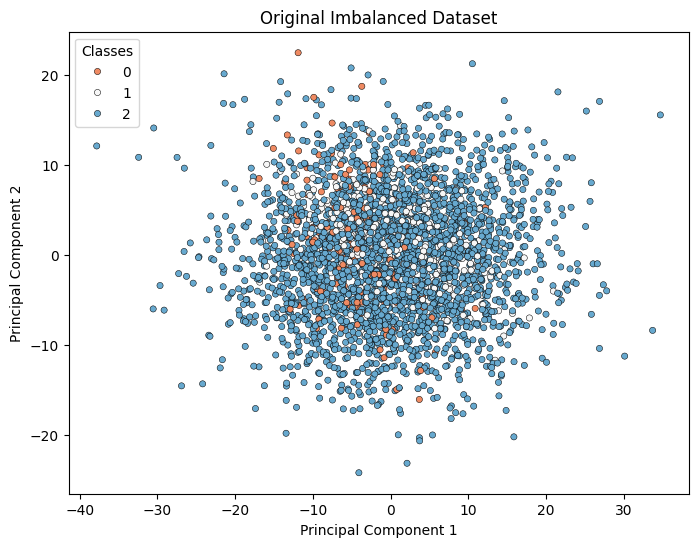

In [22]:
print("Original Dataset Distribution:", Counter(y_train))
plot_data(X_train_2d, y_train, "Original Imbalanced Dataset")

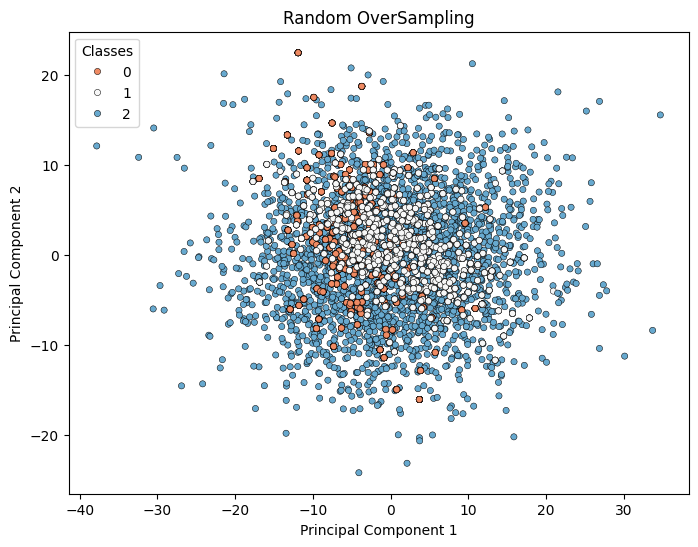

In [23]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros_2d = pca.transform(X_ros)
performance_results['RandomOverSampler'] = train_with_resampling(X_ros, y_ros, "RandomOverSampler")
plot_data(X_ros_2d, y_ros, "Random OverSampling")

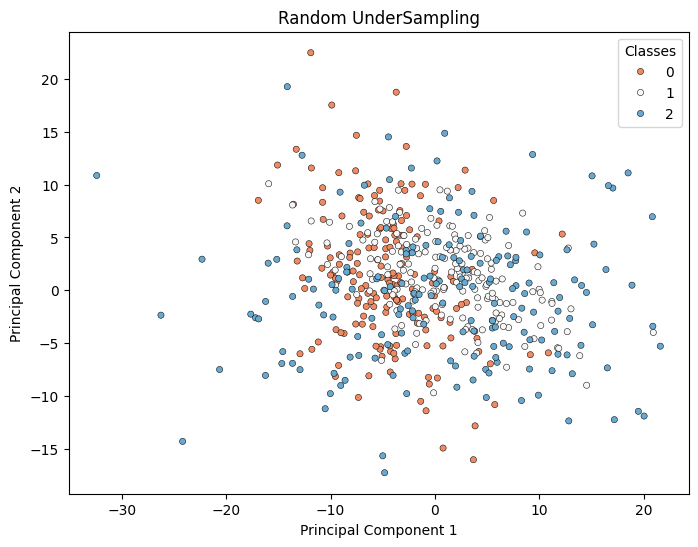

In [24]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus_2d = pca.transform(X_rus)
performance_results['RandomUnderSampler'] = train_with_resampling(X_rus, y_rus, "RandomUnderSampler")
plot_data(X_rus_2d, y_rus, "Random UnderSampling")

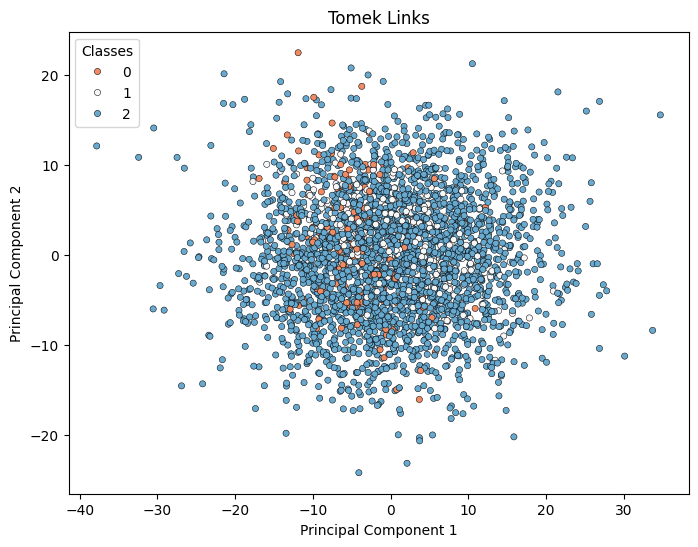

In [25]:
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)
X_tl_2d = pca.transform(X_tl)
performance_results['TomekLinks'] = train_with_resampling(X_tl, y_tl, "TomekLinks")
plot_data(X_tl_2d, y_tl, "Tomek Links")

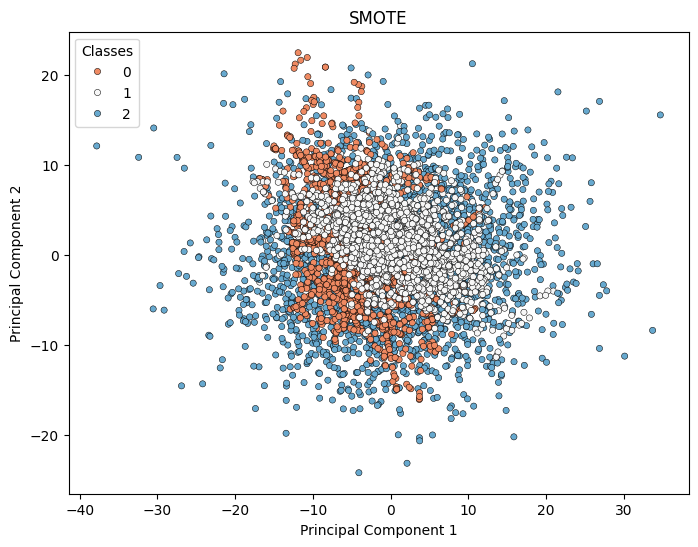

In [26]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_smote_2d = pca.transform(X_smote)
performance_results['SMOTE'] = train_with_resampling(X_smote, y_smote, "SMOTE")
plot_data(X_smote_2d, y_smote, "SMOTE")

In [27]:
model_weighted = RandomForestClassifier(random_state=42, class_weight="balanced")
model_weighted.fit(X_train, y_train)
performance_results['ClassWeighting'] = evaluate_model(model_weighted, X_test, y_test)


In [28]:
performance_df = pd.DataFrame(performance_results, index=["Accuracy", "F1 Score", "AUC"]).T
print("\nPerformance Metrics Comparison:\n", performance_df)



Performance Metrics Comparison:
                     Accuracy  F1 Score       AUC
RandomOverSampler   0.956000  0.953373  0.980185
RandomUnderSampler  0.946667  0.947792  0.975181
TomekLinks          0.954667  0.952216  0.975518
SMOTE               0.960000  0.959050  0.980591
ClassWeighting      0.948000  0.944105  0.978865


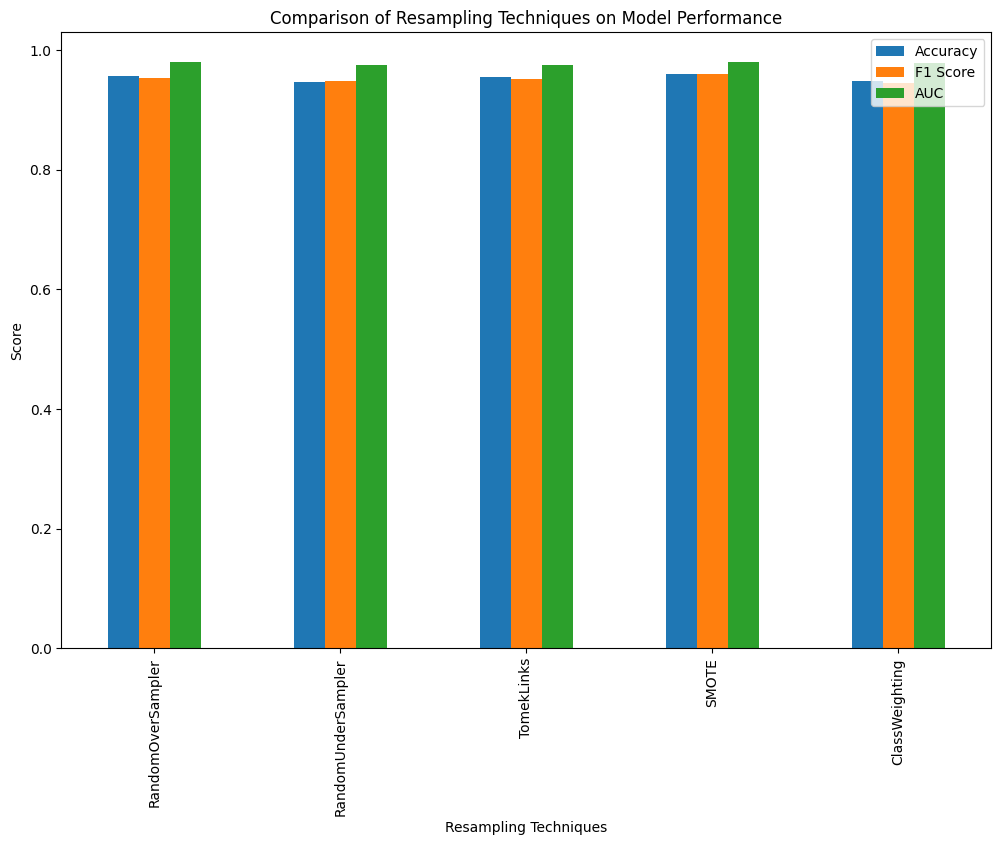

In [31]:
performance_df.plot(kind='bar', figsize=(12, 8))
plt.title("Comparison of Resampling Techniques on Model Performance")
plt.xlabel("Resampling Techniques")
plt.ylabel("Score")
plt.legend()
plt.show()

In [32]:
best_techniques = performance_df.idxmax()
best_scores = performance_df.max()
best_summary = pd.DataFrame({'Best Technique': best_techniques,'Best Score': best_scores})
print("\nBest Sampling Technique for Each Metric:\n", best_summary)


Best Sampling Technique for Each Metric:
          Best Technique  Best Score
Accuracy          SMOTE    0.960000
F1 Score          SMOTE    0.959050
AUC               SMOTE    0.980591
